In [169]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Dropout, Flatten
from keras.optimizers import Adam

In [170]:
path = '/content/drive/MyDrive/Colab Notebooks/images'
images = []
classNo = []
testRatio= 0.2
valRatio=0.2
imgDimension = (32, 32, 3)

myList = os.listdir(path)
numOfClasses=len(myList)

print(myList)
print(numOfClasses)

print("Importing Classes..........")
for x in range(0, numOfClasses):
	myPicList=os.listdir(path+"/"+str(x))
	# myData/0/img.jpg
	for y in myPicList:
		curImg=cv2.imread(path+"/"+str(x)+"/"+y)
		curImg=cv2.resize(curImg,(imgDimension[0],imgDimension[1]))
		images.append(curImg)
		classNo.append(x)
	print(x)

images=np.array(images) #1002개의 이미지, 32*32*3
classNo=np.array(classNo) #해당 이미지가 0인지 1인지 구분하는것

['1', '0']
2
Importing Classes..........
0
1


In [171]:
x_train, x_test, y_train, y_test=train_test_split(images, classNo, test_size=testRatio)
x_train, x_validation, y_train, y_validation=train_test_split(x_train, y_train, test_size=valRatio)



[320, 320]


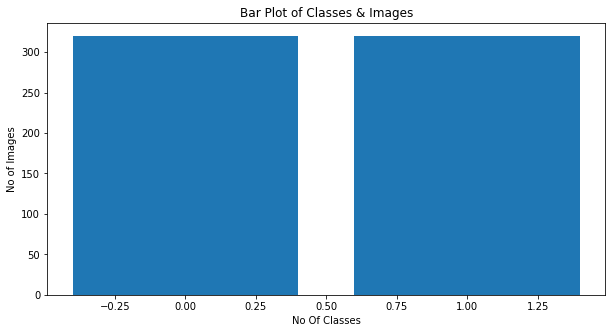

In [172]:
numOfSample=[]

for x in range(0,numOfClasses):#0<=x<2
	numOfSample.append(len(np.where(y_train==x)[0])) #[0]을 넣어주면 리스트 형식으로 바뀐다.
  #[0인 인덱스 갯수, 1인 인덱스 갯수]
 
print(numOfSample)

#데이터가 어떻게 나뉘었는지 보여주는 그래프 생성
plt.figure(figsize=(10,5))
plt.bar(range(0, numOfClasses),numOfSample)
plt.title("Bar Plot of Classes & Images")
plt.xlabel("No Of Classes")
plt.ylabel("No of Images")
plt.show()


In [173]:
def preprocessing(img):
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#컬러이미지를 그레이스케일(흑백)으로 바꿔준다.
    img=cv2.equalizeHist(img) #히스토그램 평활화, 누적분포 함수를 이용하여 영상을 개선한다 값이 0~255사이로 바뀐다. 비율에 맞춰서
    img=img/255 #정규화 (0~1사이의 값으로 만들어주기)
    return img




x_train=np.array(list(map(preprocessing, x_train))) #리스트의 모든 요소에 preprocessing 함수를 적용시킨다.
x_test=np.array(list(map(preprocessing, x_test)))
x_validation=np.array(list(map(preprocessing, x_validation)))

# print(x_train.shape) #(640, 32, 32)
# print(x_train)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1) #신경망에 적용시키기 위해 reshape
x_test=x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
x_validation=x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2],1)

# print(x_train.shape) #(640, 32,32,1)
# print(x_train)


In [174]:
dataGen=ImageDataGenerator(
	width_shift_range=0.1,
	height_shift_range=0.1,
	zoom_range=0.2,
	shear_range=0.1,
	rotation_range=10)
#더 많은 이미지를 만들기 위해 이 함수를 사용한다.

dataGen.fit(x_train) #학습시키는 함수.

y_train=to_categorical(y_train, numOfClasses) #one-hot 벡터로 만들어주어 학습을 할 수 있게 한다.
y_test=to_categorical(y_test, numOfClasses)
y_validation=to_categorical(y_validation, numOfClasses)


In [176]:
def myModel(): #신경망 모델
	sizeOfFilter1=(3,3)
	sizeOfFilter2=(3,3)
	sizeOfPool=(2,2)

	model=Sequential()#전 코드에서 reshape를 한 이유 Conv2D
	model.add((Conv2D(32, sizeOfFilter1, input_shape=(imgDimension[0],imgDimension[1],1),activation='relu')))
	model.add((Conv2D(32, sizeOfFilter1,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))

	model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
	model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))
	model.add(Dropout(0.5))


	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(numOfClasses, activation='softmax'))
	model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
	return model

model=myModel()
print(model.summary())

history=model.fit_generator(dataGen.flow(x_train, y_train,batch_size=50),
	steps_per_epoch=1000,
	epochs=3,
	validation_data=(x_validation,y_validation),
	shuffle=1)

model.save("MyTrainingModel.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)         